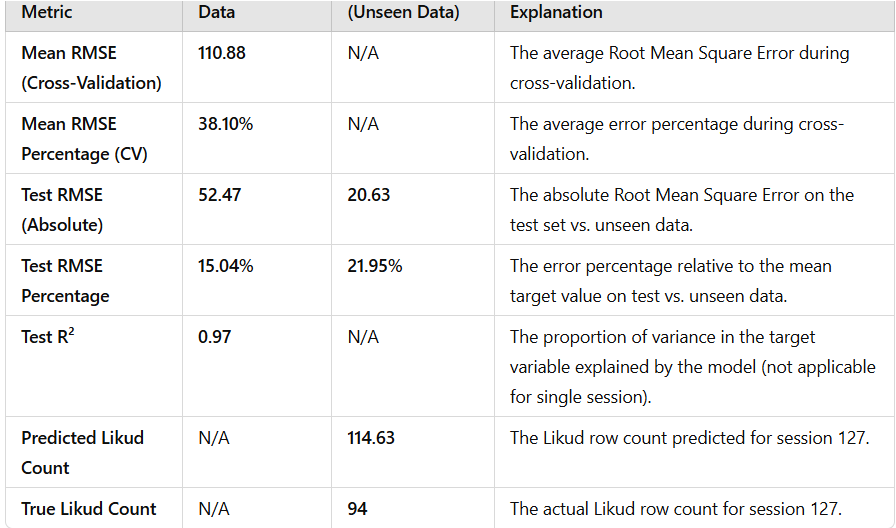

# Block 1: Train the Model with Cross-Validation and Save It



Model saved as 'linear_model_with_party_size.pkl'.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'roo

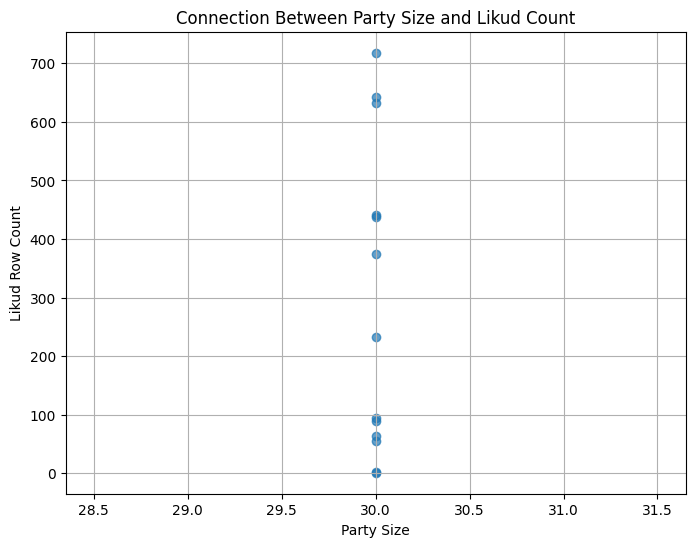

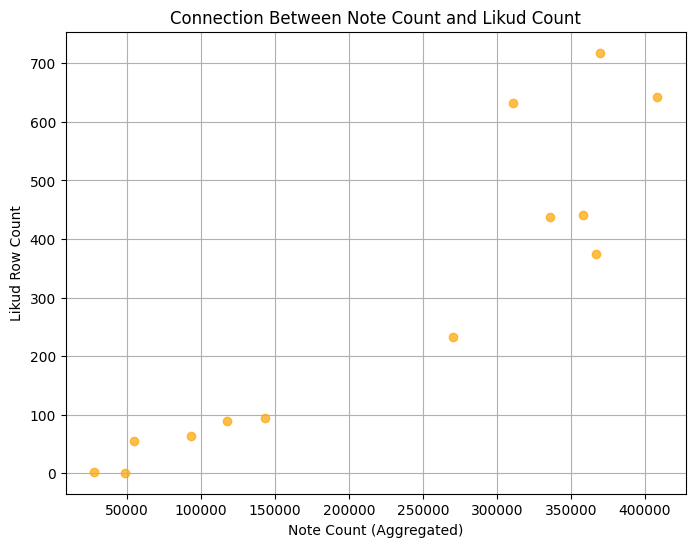

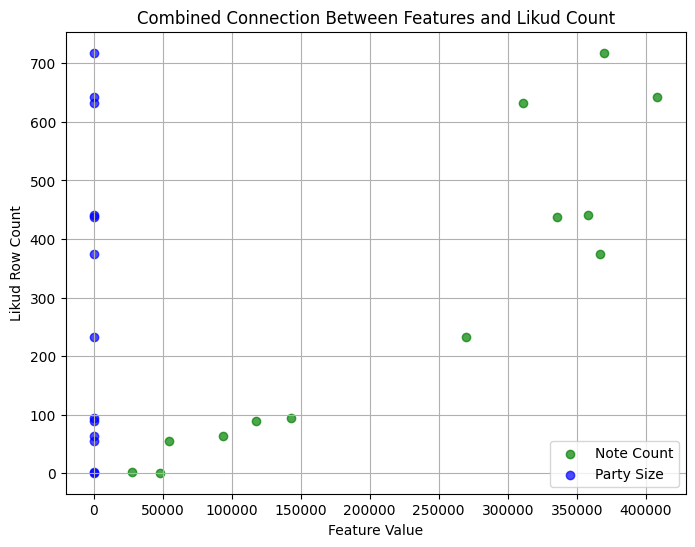

{'Mean RMSE (Cross-Validation)': '110.88', 'Mean RMSE Percentage (Cross-Validation)': '38.10%', 'Test RMSE (Absolute)': '52.47', 'Test RMSE Percentage': '15.04%', 'Test R²': '0.97'}


In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pickle
import matplotlib.pyplot as plt

# Load the original dataset
original_data_path = 'processed_combined_data.csv'  # Replace with actual path
data = pd.read_csv(original_data_path)

# Define party sizes (example mandates, update as needed)
party_sizes = {
    'הליכוד': 30,
    'יש עתיד': 17,
    'ש״ס': 9,
    'כחול לבן': 8,
    'ימינה': 7,
    'העבודה': 7,
    'יהדות התורה': 7,
    'ישראל ביתנו': 7,
    'הציונות הדתית': 6,
    'הרשימה המשותפת': 6,
    'תקווה חדשה': 6,
    'מרצ': 6,
    'הרשימה הערבית המאוחדת': 4
}

# Add `note_count` and `party_size` features
data['note_count'] = data['text'].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)
data['party_size'] = data['party'].map(party_sizes).fillna(0).astype(int)

# Aggregate features at the session level
session_features = data.groupby('session').agg({
    'note_count': 'sum',  # Total note count for the session
    'party_size': 'max',  # Max party size (Likud size)
}).reset_index()

# Calculate the target (Likud count per session)
likud_rows = data[data['party'] == 'הליכוד']
true_counts = likud_rows.groupby('session').size().reset_index(name='count')

# Merge aggregated features with the target
training_data = session_features.merge(true_counts, on='session', how='left')
training_data['count'] = training_data['count'].fillna(0).astype(int)

# Add stratification bins for target variable
training_data['count_bin'] = pd.qcut(training_data['count'], q=2, labels=False)

# Define features (X) and target (y)
X = training_data[['note_count', 'party_size']]
y = training_data['count']

# Train-test split with stratified bins
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=training_data['count_bin']
)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Save the model
with open('linear_model_with_party_size.pkl', 'wb') as file:
    pickle.dump(model, file)

print("Model saved as 'linear_model_with_party_size.pkl'.")

# Cross-validation with Stratified K-Fold
strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_rmse_scores = []
for train_idx, test_idx in strat_kfold.split(X, training_data['count_bin']):
    X_cv_train, X_cv_test = X.iloc[train_idx], X.iloc[test_idx]
    y_cv_train, y_cv_test = y.iloc[train_idx], y.iloc[test_idx]

    # Train the model on the fold
    model.fit(X_cv_train, y_cv_train)
    y_cv_pred = model.predict(X_cv_test)

    # Calculate RMSE
    rmse = mean_squared_error(y_cv_test, y_cv_pred, squared=False)
    cv_rmse_scores.append(rmse)

# Evaluate the model on the test set
y_test_pred = model.predict(X_test)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
r2_test = r2_score(y_test, y_test_pred)
mean_rmse_cv = np.mean(cv_rmse_scores)
mean_rmse_cv_percentage = (mean_rmse_cv / y.mean()) * 100
rmse_test_percentage = (rmse_test / y_test.mean()) * 100

# Plot 1: Connection between party_size and count
plt.figure(figsize=(8, 6))
plt.scatter(training_data['party_size'], training_data['count'], alpha=0.7)
plt.title("Connection Between Party Size and Likud Count")
plt.xlabel("Party Size")
plt.ylabel("Likud Row Count")
plt.grid()
plt.show()

# Plot 2: Connection between note_count and count
plt.figure(figsize=(8, 6))
plt.scatter(training_data['note_count'], training_data['count'], alpha=0.7, color='orange')
plt.title("Connection Between Note Count and Likud Count")
plt.xlabel("Note Count (Aggregated)")
plt.ylabel("Likud Row Count")
plt.grid()
plt.show()

# Plot 3: Connection between note_count, party_size, and count
plt.figure(figsize=(8, 6))
plt.scatter(training_data['note_count'], training_data['count'], alpha=0.7, label='Note Count', color='green')
plt.scatter(training_data['party_size'], training_data['count'], alpha=0.7, label='Party Size', color='blue')
plt.title("Combined Connection Between Features and Likud Count")
plt.xlabel("Feature Value")
plt.ylabel("Likud Row Count")
plt.legend()
plt.grid()
plt.show()

# Display metrics
metrics = {
    "Mean RMSE (Cross-Validation)": f"{mean_rmse_cv:.2f}",
    "Mean RMSE Percentage (Cross-Validation)": f"{mean_rmse_cv_percentage:.2f}%",
    "Test RMSE (Absolute)": f"{rmse_test:.2f}",
    "Test RMSE Percentage": f"{rmse_test_percentage:.2f}%",
    "Test R²": f"{r2_test:.2f}"
}
print(metrics)


# Block 2: Run the Model on Unseen Data


In [2]:
def run_model(file_name, true_counts_file=None):
    """
    Predict the number of Likud rows in each session based on unseen data.
    Calculate metrics (RMSE, RMSE %, R²) if true counts are provided.

    Args:
        file_name (str): Path to the unseen dataset CSV file.
        true_counts_file (str): Optional path to a file containing true Likud counts.

    Returns:
        pd.DataFrame: Predicted Likud counts per session and metrics (if true counts provided).
    """
    # Load the unseen dataset
    unseen_data = pd.read_csv(file_name)

    # Define party sizes
    party_sizes = {
        'הליכוד': 30,
        'יש עתיד': 17,
        'ש״ס': 9,
        'כחול לבן': 8,
        'ימינה': 7,
        'העבודה': 7,
        'יהדות התורה': 7,
        'ישראל ביתנו': 7,
        'הציונות הדתית': 6,
        'הרשימה המשותפת': 6,
        'תקווה חדשה': 6,
        'מרצ': 6,
        'הרשימה הערבית המאוחדת': 4
    }

    # Add `note_count` and `party_size` features
    unseen_data['note_count'] = unseen_data['text'].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)
    unseen_data['party_size'] = unseen_data['party'].map(party_sizes).fillna(0).astype(int)

    # Aggregate features at the session level
    aggregated_features = unseen_data.groupby('session').agg({
        'note_count': 'sum',
        'party_size': 'max',
    }).reset_index()

    # Load the trained model
    with open('linear_model_with_party_size.pkl', 'rb') as file:
        model = pickle.load(file)

    # Predict Likud counts
    aggregated_features['predicted_likud_count'] = model.predict(aggregated_features[['note_count', 'party_size']])

    # If true counts are provided, calculate metrics
    if true_counts_file:
        # Load the true counts file
        true_data = pd.read_csv(true_counts_file)

        # Calculate true Likud counts
        likud_rows = true_data[true_data['party'] == 'הליכוד']
        true_counts = likud_rows.groupby('session').size().reset_index(name='count')

        # Merge predictions with true counts
        results = aggregated_features.merge(true_counts, on='session', how='left')
        results['true_likud_count'] = results['count'].fillna(0).astype(int)

        # Calculate metrics
        rmse = mean_squared_error(results['true_likud_count'], results['predicted_likud_count'], squared=False)
        rmse_percentage = (rmse / results['true_likud_count'].mean()) * 100
        r2 = r2_score(results['true_likud_count'], results['predicted_likud_count'])

        # Display metrics
        metrics = {
            "RMSE (Absolute)": f"{rmse:.2f}",
            "RMSE Percentage": f"{rmse_percentage:.2f}%",
            "R²": f"{r2:.2f}"
        }
        print(metrics)

        return results[['session', 'predicted_likud_count', 'true_likud_count']], metrics

    # Return predictions if no true counts provided
    return aggregated_features[['session', 'predicted_likud_count']]


# usage example

In [ ]:
unseen_dataset_path = 'session_127_no_likud.csv'  # Replace with actual file path
true_counts_path = 'session_127.csv'  # Replace with actual file path

# Run the model and calculate metrics
predictions, metrics = run_model(unseen_dataset_path, true_counts_file=true_counts_path)
print(predictions)
print(metrics)


{'RMSE (Absolute)': '20.63', 'RMSE Percentage': '21.95%', 'R²': 'nan'}
   session  predicted_likud_count  true_likud_count
0      127             114.630274                94
{'RMSE (Absolute)': '20.63', 'RMSE Percentage': '21.95%', 'R²': 'nan'}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
